# Dynamic Company Embedding

This notebook aims to look at the word embeddings for companies and look at whats changed between the years 2016 to 2018, specifically using 

<!-- - tf-idf (term frequency - inverse document frequency)
- LDA (Latent Dirichlet Allocation)
- LSA (Latent Semantic Analysis)
- word2vec
- doc2vec -->

In [21]:
import os
import json
import pandas as pd
import numpy as np
import sys
sys.path.insert(0, '..')
%load_ext autoreload
%autoreload 2
%aimport std_func

# Hide warnings
import warnings
warnings.filterwarnings("ignore")

data = pd.read_csv("../data/preprocessed.csv")
data_t = pd.read_csv("../mary/filtered_timeseries_data.csv")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



We will examine these five companies and their sequential annual reports: 
- `OKTA`
- `Z-Scaler`
- `NFLX`
- `IBM`
- `GE`

In [35]:
the_five = pd.DataFrame.from_dict(
    {1660134:"OKTA",1713683:"Z-Scaler",1065280:"NFLX",51143:"IBM",40545:"GE"},
    orient = "index").reset_index().rename(columns={"index":"CIK",0:"Name"})

data_five_raw = pd.read_csv("../data/bq_dynamic_five.csv")
data_five_raw["CIK"] = data_five_raw["financialEntity"].str.split("=", expand = True).iloc[:,1]
data_five = std_func.clean(data_five_raw).drop(columns = ["coDescription", "coDescription_lemmatized"])
data_five = pd.merge(data_five, the_five, how = "left", on = "CIK")

In [3]:
print("We have {} unique companies that are within the corpus of data we will examine.".format(len(pd.unique(data_t["CIK"]))))

We have 564 unique companies that are within the corpus of data we will examine.


In [4]:
# The companies with names have them, the ones that don't are NaN
clean = pd.merge(data_t,
    data_five, how = "left", on="CIK")

clean['Name'] = clean['Name_y'].fillna(clean['Name_x'])
clean = clean.drop(["...1","Unnamed: 0","reports"],axis = 1)
# clean
# final = clean
# Adding on the data from the 5 companies
final = pd.concat([data_t,data_five]).reset_index()
# final = final.merge(pd.Series(final.groupby("CIK").size(), name = "reports"), how = "left", on = "CIK") \
    # .sort_values(["CIK","filingDate"]).reset_index()
final

,index,...1,Unnamed: 0,filingDate,reportingDate,financialEntity,CIK,coDescription_stopwords,reports,Ticker,Name,Exchange,SIC,Business,Incorporated,IRS,SIC_Descrip
0,0,1948.0,1948.0,2016-12-06 22:05:12 UTC,2016-10-01,financialEntities/params;cik=3545,3545,alico alico wa incorporated law state florida ...,3.0,ALCO,Alico Inc,NASDAQ,100.0,FL,FL,590906081.0,Agrigultural Production - Crops
1,1,1456.0,1456.0,2017-12-11 22:13:06 UTC,2017-10-01,financialEntities/params;cik=3545,3545,alico alico wa incorporated law state florida ...,3.0,ALCO,Alico Inc,NASDAQ,100.0,FL,FL,590906081.0,Agrigultural Production - Crops
2,2,83.0,83.0,2018-12-06 21:58:38 UTC,2018-10-01,financialEntities/params;cik=3545,3545,alico alico wa incorporated law state florida ...,3.0,ALCO,Alico Inc,NASDAQ,100.0,FL,FL,590906081.0,Agrigultural Production - Crops
3,3,832.0,832.0,2016-05-25 20:19:47 UTC,2016-04-01,financialEntities/params;cik=4457,4457,north america largest moving storage operator ...,3.0,UHAL,Amerco,NASDAQ,7500.0,NV,NV,880106815.0,"Automotive Rentals, No Drivers"
4,4,1242.0,1242.0,2017-05-24 20:07:02 UTC,2017-04-01,financialEntities/params;cik=4457,4457,north america largest moving storage operator ...,3.0,UHAL,Amerco,NASDAQ,7500.0,NV,NV,880106815.0,"Automotive Rentals, No Drivers"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1703,11,NaN,NaN,2011-02-25T21:33:50Z,NaN,financialEntities/params;cik=40545,40545,al unless otherwise indicated context use term...,NaN,NaN,GE,NaN,NaN,NaN,NaN,NaN,NaN
1704,12,NaN,NaN,2012-02-24T21:29:18Z,NaN,financialEntities/params;cik=40545,40545,l unless otherwise indicated context use term ...,NaN,NaN,GE,NaN,NaN,NaN,NaN,NaN,NaN
1705,13,NaN,NaN,2013-02-26T22:17:59Z,NaN,financialEntities/params;cik=40545,40545,l unless otherwise indicated context use term ...,NaN,NaN,GE,NaN,NaN,NaN,NaN,NaN,NaN
1706,14,NaN,NaN,2014-02-27T21:55:58Z,NaN,financialEntities/params;cik=40545,40545,l unless otherwise indicated context use term ...,NaN,NaN,GE,NaN,NaN,NaN,NaN,NaN,NaN


## Diving into the embeddings

In this section, we look at the three embedding techniques employed earlier and how they can help us analyze how four companies have changed year after year.

### tf-idf (term frequency - inverse document frequency)
For tf-idf we can look directly at the terms extracted and analyze how they've changed over time.

We have written a function that computes the 20 terms that experienced the largest changes in value year over year, for each company and each year. Below are the results after running our data through it.

In [22]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

# combine the techniques since tf-idf only augments count vectorized documents
pipe = Pipeline([('count', CountVectorizer(ngram_range = (2,4), max_features = 1000)),
                  ('tfidf', TfidfTransformer())]).fit(final["coDescription_stopwords"])

tfidf = pd.DataFrame(pipe.transform(final["coDescription_stopwords"]).toarray())
data_tfidf = pd.concat([final.loc[:,["filingDate","CIK", "Name"]],tfidf], axis = 1)
delta_tfidf = std_func.deltas(final, data_tfidf, pipe.get_feature_names_out().tolist()) \
    .rename(columns = {0:"CIK", 1:"Name", 2: "YoY", 3:"Term", 4:"Delta"})
delta_tfidf

,CIK,Name,YoY,Term,Delta
0,3545,Alico Inc,year 0 to year 1,regulatory approval,0.082976
1,3545,Alico Inc,year 0 to year 1,financial condition,-0.076110
2,3545,Alico Inc,year 0 to year 1,supply chain,-0.056592
3,3545,Alico Inc,year 0 to year 1,based upon,0.044193
4,3545,Alico Inc,year 0 to year 1,federal government,0.040511
...,...,...,...,...,...
68595,40545,GE,year 2 to year 3,loan portfolio,0.021661
68596,40545,GE,year 2 to year 3,saving loan,0.021661
68597,40545,GE,year 2 to year 3,wide range,0.021126
68598,40545,GE,year 2 to year 3,federal reserve,0.020260


#### OKTA

We can now examine OKTA and which terms experienced the largest changes in value year over year.

In [34]:
# OKTA
OKTA = delta_tfidf[delta_tfidf.iloc[:,0] == 1660134].iloc[:60,:].groupby("YoY").head(5)

##### 2018 - 2019

The earliest filing on OKTA available is in 2018. We can see from this analysis that between 2018 and 2019, the largets decrease in tf-idf value (term importance) was _"mobile application"_. But on the rise of importance were terms such as _"help customer"_ and _"customer support"_. 

From Wikipedia, 

>It provides cloud software that helps companies manage and secure user authentication into applications, and for developers to build identity controls into applications, website web services and devices.

We can reason that throughout 2019, Okta shifted their focus away from mobile applications to some degree, and increased their focus on customer care.

Assuming they have many business customers with a variety of applications, we could consider this the year Okta **shifted their services a little further from mobile**.

In [32]:
OKTA[:5]

,CIK,Name,YoY,Term,Delta
68080,1660134,OKTA,year 0 to year 1,mobile application,-0.296099
68081,1660134,OKTA,year 0 to year 1,help customer,0.087498
68082,1660134,OKTA,year 0 to year 1,customer support,0.075500
68083,1660134,OKTA,year 0 to year 1,market segment,0.070916
68084,1660134,OKTA,year 0 to year 1,outside united state,0.068456


##### 2019 - 2020

In 2020, it seems the _"end user"_ became a largest importance to Okta, supported by the increased importance of _"customer need"_ as well.

This year could be categorized as a shift toward focusing on **users**.

In [33]:
OKTA[5:10]

,CIK,Name,YoY,Term,Delta
68100,1660134,OKTA,year 1 to year 2,end user,0.125978
68101,1660134,OKTA,year 1 to year 2,market segment,-0.124971
68102,1660134,OKTA,year 1 to year 2,customer need,0.114765
68103,1660134,OKTA,year 1 to year 2,technology platform,0.071739
68104,1660134,OKTA,year 1 to year 2,new technology,0.057768


##### 2020 - 2021

We see an increase in importance of terms like _"merger agreement"_, _"common stock"_, _"per share"_, and _"equity interest"_. These terms are all related to mergers and acquisitions and a quick search reveals that in May of 2021, they successfully completed a merger with another company named auth0.

You could consider **this M&A event to carry the most importance to Okta's shareholders** at the end of 2021, which is why it was given such importance in the the Business Description section.

In [30]:
OKTA[10:15]

,CIK,Name,YoY,Term,Delta
68120,1660134,OKTA,year 2 to year 3,merger agreement,0.256254
68121,1660134,OKTA,year 2 to year 3,common stock,0.134086
68122,1660134,OKTA,year 2 to year 3,per share,0.119493
68123,1660134,OKTA,year 2 to year 3,equity interest,0.105603
68124,1660134,OKTA,year 2 to year 3,purchase price,0.082064


#### Z-Scaler

> Z-scaler is a cloud security company, headquartered in San Jose, California. The company’s cloud-native technology platform, the Zscaler Zero Trust Exchange, is designed to help enterprise customers secure their employees, applications, and data as infrastructure and applications move to the cloud and as employees connect to work remotely, off the traditional corporate network.

- Wikipedia

Knowing what kind of company Z-Scaler is now, lets try to infer what these changes in term importances mean.

##### 2019-2020

Unfortunately, we only have 2 years of data for Z-Scaler. In 2020, it seems they had a large focus on _"data center"_, and increases in importance for terms that included _"service"_. We could infer that in 2020, the company which provides security to its clients in the pulic cloud or private data centers had an increased focus on the latter group of services. 

In [26]:
# Z-Scaler
delta_tfidf[delta_tfidf.iloc[:,0] == 1713683].iloc[:60,:].groupby("YoY").head(5)

,CIK,Name,YoY,Term,Delta
68320,1713683,Z-Scaler,year 0 to year 1,data center,0.123903
68321,1713683,Z-Scaler,year 0 to year 1,approximately billion,-0.074951
68322,1713683,Z-Scaler,year 0 to year 1,service include,0.065553
68323,1713683,Z-Scaler,year 0 to year 1,service provider,0.064729
68324,1713683,Z-Scaler,year 0 to year 1,credit card,-0.041534


#### Netflix

Netflix is a company that usually needs no introduction, but I will give one regardless.

> Netflix, Inc. is an American subscription streaming service and production company. Launched on August 29, 1997, it offers a film and television series library through distribution deals as well as its own productions, known as Netflix Originals.

Lets look at what changes Netflix as a company went through over the years.

##### 2008 - 2009

As you recall, these are the terms that experienced the largest absolute changes in tf-idf value year over year. This implies that in 2009, Netflix talked about their _"business model"_, _"customer support" and "proprietary technology"_ less. It's hard to guage what this translated into but is interesting nonetheless.

In [47]:
# Netflix
nlfx = delta_tfidf[delta_tfidf.iloc[:,0] == 1065280].iloc[:80,:].groupby("YoY").head(5)
nlfx[:5]

,CIK,Name,YoY,Term,Delta
67680,1065280,NFLX,year 0 to year 1,business model,-0.089397
67681,1065280,NFLX,year 0 to year 1,throughout united,0.082932
67682,1065280,NFLX,year 0 to year 1,customer support,-0.067874
67683,1065280,NFLX,year 0 to year 1,high level,-0.061801
67684,1065280,NFLX,year 0 to year 1,proprietary technology,-0.058393


##### 2009 - 2010

In 2010, it seems as though an emphasis of _"license agreement"_, _"third party"_, and _"intellectual property"_ all increased in importance. 

This is quite important, as according to Britannica,

> In 2010 Netflix introduced a streaming-only plan that offered unlimited streaming service but no DVDs. Netflix then expanded beyond the United States by offering the streaming-only plan in Canada in 2010, in Latin America and the Caribbean in 2011, and in the United Kingdom, Ireland, and Scandinavia in 2012.

This year marked a huge change in Netflix's business model, and of course their company business description shows this.

In [48]:
nlfx[5:10]

,CIK,Name,YoY,Term,Delta
67700,1065280,NFLX,year 1 to year 2,high level,0.105325
67701,1065280,NFLX,year 1 to year 2,proprietary technology,-0.074626
67702,1065280,NFLX,year 1 to year 2,license agreement,0.071091
67703,1065280,NFLX,year 1 to year 2,third party,0.060303
67704,1065280,NFLX,year 1 to year 2,intellectual property,0.045675


##### 2010 - 2011

As Netflix's new business venture started to take off, so did their investments into it and its importance to the business, as highlighted by the increased importance in terms such as _"web site"_ and _"united state"_ as they first released the streaming service in the United States. Throughout 2011, Netflix experienced quite poor demand as consumers were still recovering from the 2008 economic crash, so Netflix had to assure it's investors of it's ability to stay in business. That could explain why _"investor relation"_ gained a high degree of importance.

In [49]:
nlfx[10:15]

,CIK,Name,YoY,Term,Delta
67720,1065280,NFLX,year 2 to year 3,web site,-0.323084
67721,1065280,NFLX,year 2 to year 3,investor relation,0.191036
67722,1065280,NFLX,year 2 to year 3,united state,0.166511
67723,1065280,NFLX,year 2 to year 3,sec filing,0.156843
67724,1065280,NFLX,year 2 to year 3,license agreement,-0.140434


##### 2011 - 2012

According to above, Netflix expanded to the United Kingdom among other countries in 2012, which may explain the decrease in focus/importance of _"united state"_. The rest of the changes to term importance seem quite unexplainable at a glance, so make of it what you will. :)

In [52]:
nlfx[15:20]

,CIK,Name,YoY,Term,Delta
67740,1065280,NFLX,year 3 to year 4,united state,-0.126168
67741,1065280,NFLX,year 3 to year 4,web site,-0.122782
67742,1065280,NFLX,year 3 to year 4,consolidated net,0.111090
67743,1065280,NFLX,year 3 to year 4,service offering,-0.100654
67744,1065280,NFLX,year 3 to year 4,supplementary data,0.099262


#### General Electric

General Electric is a household brand that manufacturers everything from washing machines to jet engines. As per Wikipedia,

> General Electric Company (GE) is an American multinational conglomerate incorporated in New York State and headquartered in Boston. Until 2021, the company operated in sectors including aviation, power, renewable energy, digital industry, additive manufacturing, locomotives, and venture capital and finance but has since divested from several areas, now primarily consisting of the first four segments.

So they have their hands in many basics, what can changes in the words used in their annual reports tell us about what they're doing, as a company year to year?

##### 2011 - 2012

In 2012, terms such as _"oil gas"_, _"financial service"_, and _"completed acquisition"_ increased in importance implying GE may have made significant investements into the Oil & Gas industry as well as the Financial Services industry, perhaps through acquisitions.

From the Acquisitions section on their Wikipedia page, during 2011 and 2012,

> In March 2011, GE announced that it had completed the acquisition of privately held Lineage Power Holdings from The Gores Group. In April 2011, GE announced it had completed its purchase of John Wood plc's Well Support Division for $2.8 billion.

> In 2011, GE Capital sold its $2 billion Mexican assets to Santander for 162 million and exit the business in Mexico. Santander additionally assumed the portfolio debts of GE Capital in the country. Following this, GE Capital focused in its core business and shed its non-core assets.

> In June 2012, CEO and President of GE Jeff Immelt said that the company would invest ₹3 billion to accelerate its businesses in Karnataka. In October 2012, GE acquired $7 billion worth of bank deposits from MetLife Inc.

All transactions were related to the energy sector (related to Oil & Gas) or finance (Santander is a large Spanish bank)

In [53]:
# GE
ge = delta_tfidf[delta_tfidf.iloc[:,0] == 40545].iloc[:60,:].groupby("YoY").head(5)
ge[:5]

,CIK,Name,YoY,Term,Delta
68360,40545,GE,year 0 to year 1,oil gas,0.100988
68361,40545,GE,year 0 to year 1,financial service,0.076844
68362,40545,GE,year 0 to year 1,product service,-0.073995
68363,40545,GE,year 0 to year 1,completed acquisition,0.062822
68364,40545,GE,year 0 to year 1,service segment,0.048669


##### 2012 - 2013

In 2013, it seems GE made further divestments in financial services as terms such as _"credit card"_ and _"financial service"_ have decreased in importance,as well as _"power generation"_ and _"real estate"_ to a lesser extent. A quick Google search lends no meaning to these changes in General Electric's business, so there are currently no conclusions to draw from this.

In [54]:
ge[5:10]

,CIK,Name,YoY,Term,Delta
68380,40545,GE,year 1 to year 2,credit card,-0.093631
68381,40545,GE,year 1 to year 2,financial service,-0.069370
68382,40545,GE,year 1 to year 2,power generation,-0.057595
68383,40545,GE,year 1 to year 2,real estate,-0.045220
68384,40545,GE,year 1 to year 2,ownership interest,-0.040749


##### 2013 - 2014

As with 2013, it seems these changes in term importance are quite broad for 2014. One term that does stand out however is that _"north american"_ as they opened a new facility in Cincinnati this year.

> Later in 2014, General Electric announced plans to open its global operations center in Cincinnati, Ohio. The Global Operations Center opened in October 2016 as home to GE's multifunctional shared services organization. It supports the company's finance/accounting, human resources, information technology, supply chain, legal and commercial operations, and is one of GE's four multifunctional shared services centers worldwide in Pudong, China; Budapest, Hungary; and Monterrey, Mexico.

In [55]:
ge[10:15]

,CIK,Name,YoY,Term,Delta
68400,40545,GE,year 2 to year 3,real estate,0.055807
68401,40545,GE,year 2 to year 3,entered agreement,-0.045193
68402,40545,GE,year 2 to year 3,north american,0.044864
68403,40545,GE,year 2 to year 3,financial service,-0.040293
68404,40545,GE,year 2 to year 3,first quarter,0.037850


### word2vec

Now the issue with word2vec, is that the output feature columns don't represent a term or topic. Luckily most of our data is already labelled and comes with industry classifications.

In [129]:
print("There are {} industries listed in our data of 564 companies.".format(len(final["SIC_Descrip"].unique())))

There are 171 industries listed in our data of 564 companies.


Lets perform word2vec on this data. Once we have embeddings for each company, we can find a median vector of each industry which we can use as a pseudo-industry embedding. This vector is what we will use to compare companies to and infer whether they've moved away or toward any given industries. This will be calculated on the entire time series of company filings. 

Below is the code that extracts this information.

In [130]:
from gensim.models.word2vec import Word2Vec
from gensim import utils
from sklearn.metrics.pairwise import cosine_similarity

time_processed = final["coDescription_stopwords"].apply(lambda x: utils.simple_preprocess(x))

# https://stackoverflow.com/questions/46560861/relation-between-word2vec-vector-size-and-total-number-of-words-scanned
model_w = Word2Vec(time_processed, vector_size = 300)

def doc_to_vec(text):
    word_vecs = [model_w.wv[w] for w in text if w in model_w.wv]
    
    if len(word_vecs) == 0:
        return np.zeros(model_w.vector_size)
    
    return np.mean(word_vecs, axis = 0)

doc_vec = pd.DataFrame(time_processed.apply(doc_to_vec).tolist())

data_w2v = pd.concat([final.loc[:,["filingDate","CIK", "Name", "SIC_Descrip"]],doc_vec],axis = 1)

industry_vectors = data_w2v.iloc[:,3:].groupby("SIC_Descrip").mean()

To calculate distance between the annual reports of our five companies and the industries, we will compute the cosine similarity scores.

For each year of filings, we only care about the industries with the smallest distance (greatest consine similarity) and how these top industries have changed over time.

The inner workings of this are quite simple. 

1. For each year, we extract the top 5 industries with the highest similarity scores. These indsutry names are stored and this step is repeated.
2. Since companies change year over year, different industries could appear in the top 5, which is why some figures below will have more than 5 industries visualized.

#### Okta

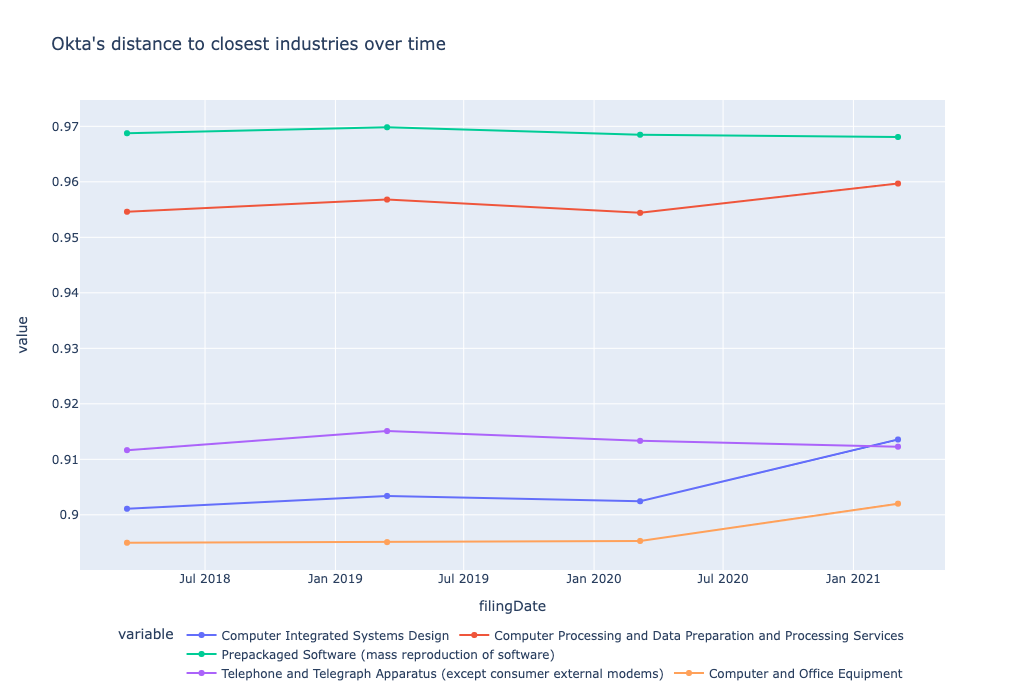

In [274]:
okta_w2v = pd.concat([data_w2v[data_w2v.loc[:,"CIK"] == 1660134].iloc[:,0].reset_index(drop=True),
           pd.DataFrame(cosine_similarity(data_w2v[data_w2v.loc[:,"CIK"] == 1660134].iloc[:,4:], industry_vectors),
                        columns = industry_vectors.index.tolist())],
          axis = 1)

# Gets the list of top industries associated with okta throughout it's history
okta_industries = set((okta_w2v.iloc[0,1:].sort_values(ascending = False).head(5).index.tolist()))
for i in np.arange(1,okta_w2v.shape[0]):
    okta_industries.update(okta_w2v.iloc[i,1:].sort_values(ascending = False).head(5).index.tolist())

std_func.dynamic_plt(okta_w2v, okta_industries, "Okta")

The above plot illustrates for the top 5 closest industries to Okta, its distance to its closest five industries stayed quite consistent over the 4 time points, while between 2020 to 2021 its similarity to **Computer Integrated Systems Design** increased greatly and its similarity to **"Computer and Office Equipment"** increased a bit less.

Okta's main service is to handle identity and access management, so naturally integrating into it's client's services and internal systems is expected.

The increase in similarity to **"Computer and Office Equipment"** is harder to interpret, but perhaps it was due to the increased mentions of work from home setups within many companies and how Okta's services should adapt/have adapted to it.

#### Z-Scaler

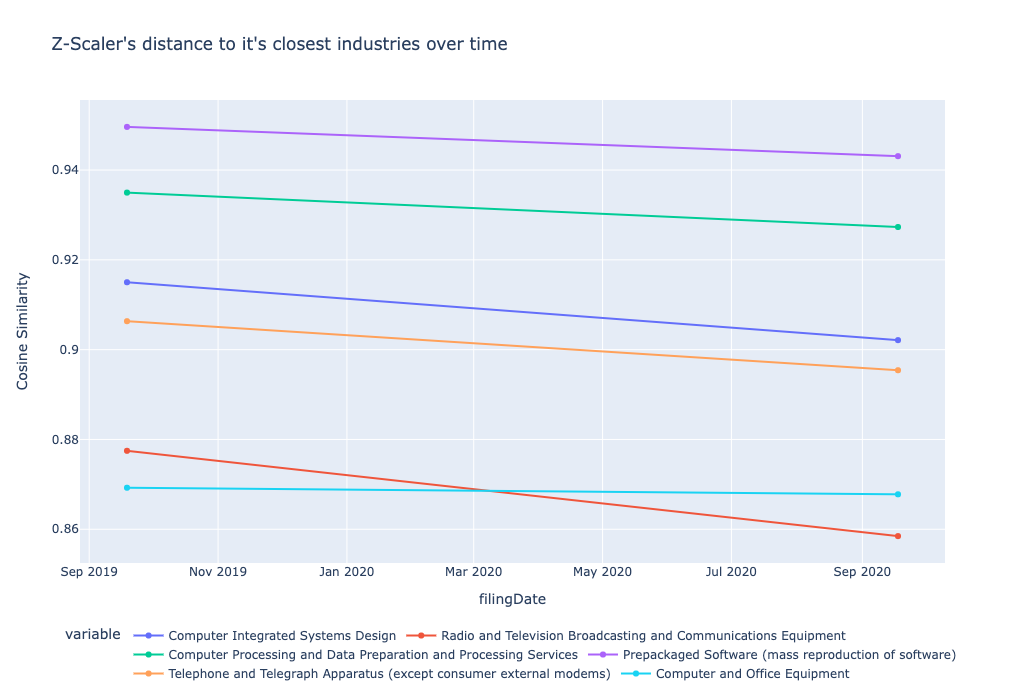

In [282]:
zs_w2v = pd.concat([data_w2v[data_w2v.loc[:,"CIK"] == 1713683].iloc[:,0].reset_index(drop=True),
           pd.DataFrame(cosine_similarity(data_w2v[data_w2v.loc[:,"CIK"] == 1713683].iloc[:,4:], industry_vectors),
                        columns = industry_vectors.index.tolist())],
          axis = 1)

# Gets the list of top industries associated with okta throughout it's history
zs_industries = set((zs_w2v.iloc[0,1:].sort_values(ascending = False).head(5).index.tolist()))
for i in np.arange(1,zs_w2v.shape[0]):
    zs_industries.update(zs_w2v.iloc[i,1:].sort_values(ascending = False).head(5).index.tolist())

std_func.dynamic_plt(zs_w2v, zs_industries, "Z-Scaler")

Across the board, it seems Z-Scaler's similarity to it's closest industries decreased. This suggests that Z-Scaler is potentially moving away from the computer/software related industry as a whole.

This interpretation should be taken with a large grain of salt, as we are only visualizing changes over one year.

#### Netflix

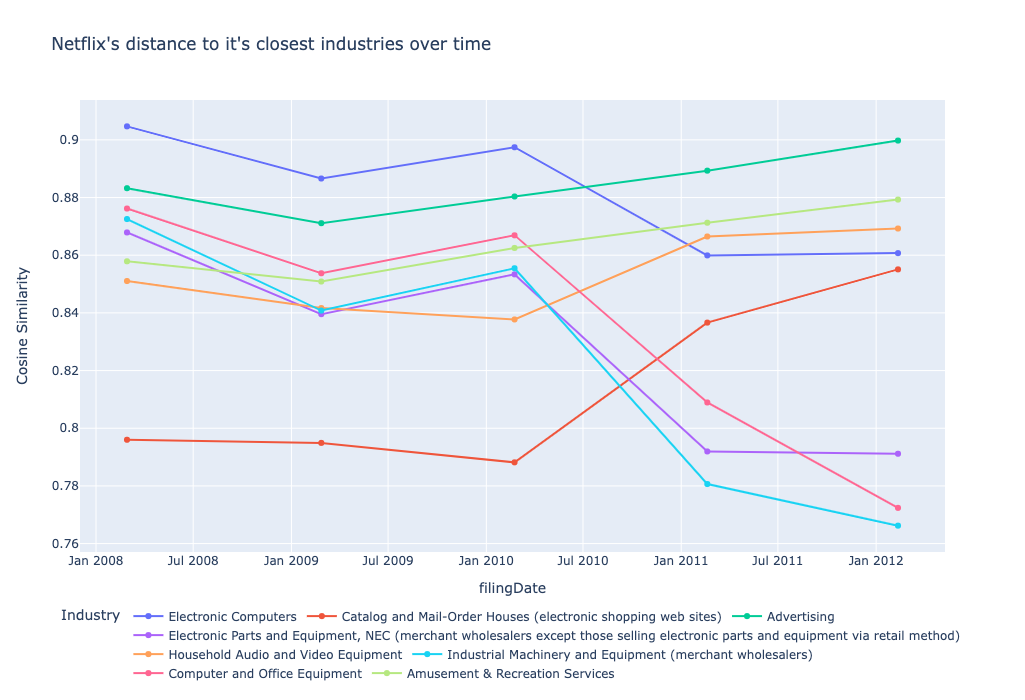

In [284]:
nlfx_w2v = pd.concat([data_w2v[data_w2v.loc[:,"CIK"] == 1065280].iloc[:,0].reset_index(drop=True),
           pd.DataFrame(cosine_similarity(data_w2v[data_w2v.loc[:,"CIK"] == 1065280].iloc[:,4:], industry_vectors),
                        columns = industry_vectors.index.tolist())],
          axis = 1)

# Gets the list of top industries associated with okta throughout it's history
nlfx_industries = set((nlfx_w2v.iloc[0,1:].sort_values(ascending = False).head(5).index.tolist()))
for i in np.arange(1,nlfx_w2v.shape[0]):
    nlfx_industries.update(nlfx_w2v.iloc[i,1:].sort_values(ascending = False).head(5).index.tolist())

std_func.dynamic_plt(nlfx_w2v, nlfx_industries, "Netflix")

Netflix has experiences quite a tumultuous 5 years, which is no surprise as this was the exact turning point when they first released their streaming service.

This chart quite splendidly depicts how Netflix moved away from industries such as **"Electronic Computers"**, **"Computer and Office Equipment"** and **"Electronic Parts and Equipment"** significantly. In 2008, they released a home set top box device manufactured by Roku which allowed cusotmers to play movies and shows all for one fee. As most people are familiar, they moved away from that and started offering their streaming services online starting 2010.

What can't be easily explained are the dramatic increases in the **"Catalog and mail-order houses (electronic shopping websites)"** and **"Household Audio and Video Equipment"** industries. Presumably their sale of streaming services could be purchased on Netflix's website, thereby making them an electronic shopping website but that still doesn't explain the increase in the latter industry. At this stage of the company, Netflix was moving away from physical products and toward their streaming service business.

#### General Electric

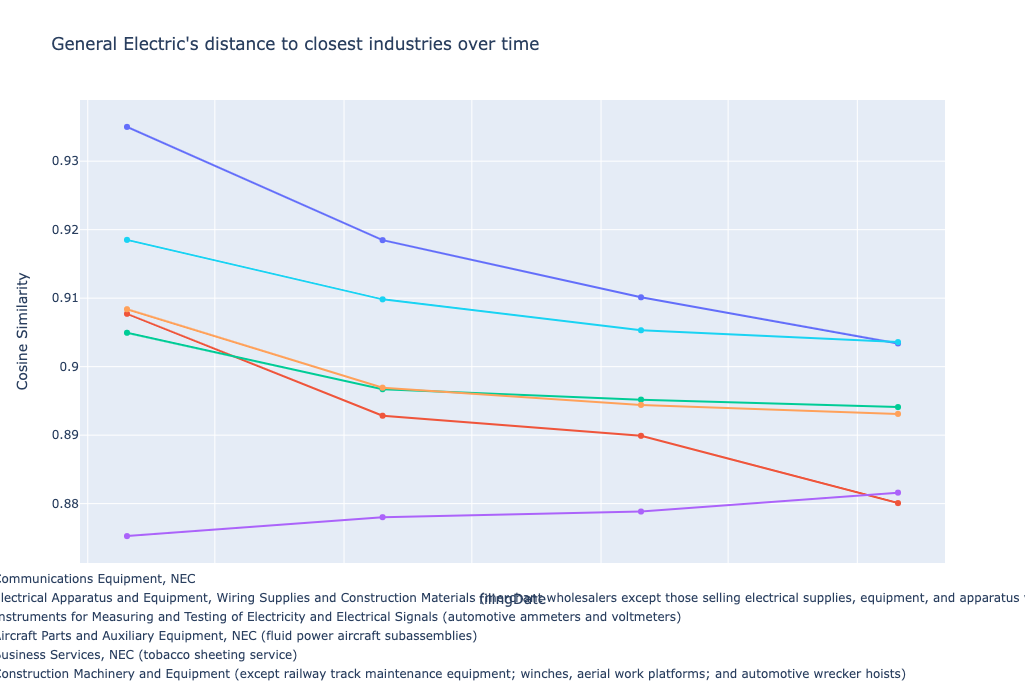

In [281]:
ge_w2v = pd.concat([data_w2v[data_w2v.loc[:,"CIK"] == 40545].iloc[:,0].reset_index(drop=True),
           pd.DataFrame(cosine_similarity(data_w2v[data_w2v.loc[:,"CIK"] == 40545].iloc[:,4:], industry_vectors),
                        columns = industry_vectors.index.tolist())],
          axis = 1)

# Gets the list of top industries associated with okta throughout it's history
ge_industries = set((ge_w2v.iloc[0,1:].sort_values(ascending = False).head(5).index.tolist()))
for i in np.arange(1,ge_w2v.shape[0]):
    ge_industries.update(ge_w2v.iloc[i,1:].sort_values(ascending = False).head(5).index.tolist())

std_func.dynamic_plt(ge_w2v, ge_industries, "General Electric")

Finally, we have General Electric. It's quite interesting to see how its top industries year over year have declined consistently. The movement of this graph implies General Electric was in a large divestment stage in its top related industries.

#### Notes on how the analysis was performed

In the above word2vec section, one aspect of some companies may have been missed. That is for companies with large divestments in its top related industries, what did they move **toward**? Our analysis here focused primarily on the industries identifies as being the most similar as its quite informative to speak to industries a company operates within. But for some companies such as Netflix and General Electric, they could have experience large increases in similarity with industries that are very far from where their embeddings are. 

For example, Netflix could be moving very close to the **"Prepackaged Software industry"**, but because its similarity is very low (say .50), even large increases to say 0.75 would go unnoticed because that is still too low to be considered one of Netflix's top 5 industries.

### doc2vec

Now we'll look at how embeddings created using doc2vec have changed over time for our four companies.

In [286]:
from gensim.models import doc2vec
from collections import namedtuple

docs = []
analyzedDocument = namedtuple('AnalyzedDocument', 'words tags')
for i, text in enumerate(final["coDescription_stopwords"]):
    words = text.lower().split()
    tags = [i]
    docs.append(analyzedDocument(words, tags))

# Train model (set min_count = 1, if you want the model to work with the provided example data set)

model = doc2vec.Doc2Vec(docs, vector_size = 100, window = 10, min_count = 1, workers = 4)

doc_vec_2 = pd.DataFrame([model.dv[doc] for doc in np.arange(0,len(docs))])
data_d2v = pd.concat([final.loc[:,["filingDate","CIK", "Name", "SIC_Descrip"]],doc_vec_2],axis = 1)

industry_vectors_d2v = data_d2v.iloc[:,3:].groupby("SIC_Descrip").mean()

#### Okta

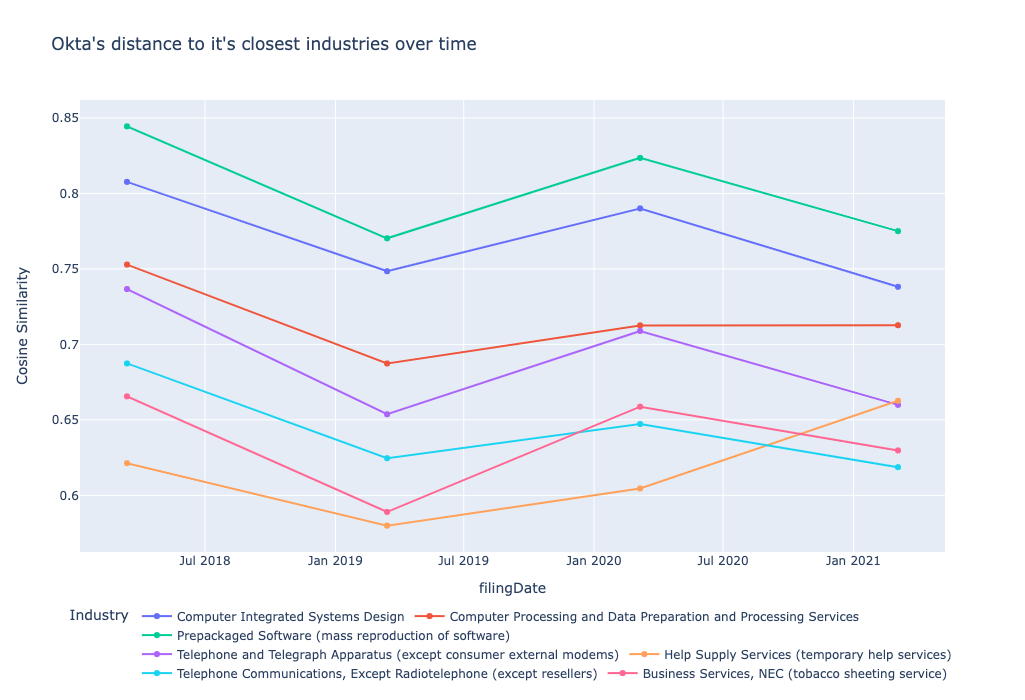

In [291]:
okta_d2v = pd.concat([data_d2v[data_d2v.loc[:,"CIK"] == 1660134].iloc[:,0].reset_index(drop=True),
           pd.DataFrame(cosine_similarity(data_d2v[data_d2v.loc[:,"CIK"] == 1660134].iloc[:,4:], industry_vectors_d2v),
                        columns = industry_vectors.index.tolist())],
          axis = 1)

# Gets the list of top industries associated with okta throughout it's history
okta_industries_d2v = set((okta_d2v.iloc[0,1:].sort_values(ascending = False).head(5).index.tolist()))
for i in np.arange(1,okta_d2v.shape[0]):
    okta_industries_d2v.update(okta_d2v.iloc[i,1:].sort_values(ascending = False).head(5).index.tolist())

std_func.dynamic_plt(okta_d2v, okta_industries_d2v, "Okta")

The above plot illustrates for the top 5 closest industries to Okta, calculated using doc2vec embeddings. It's quite interesting to see "Business Services, NEC (tobacco sheeting service)" as an industry be so highly ranked as an industry for Okta here.

#### Z-Scaler

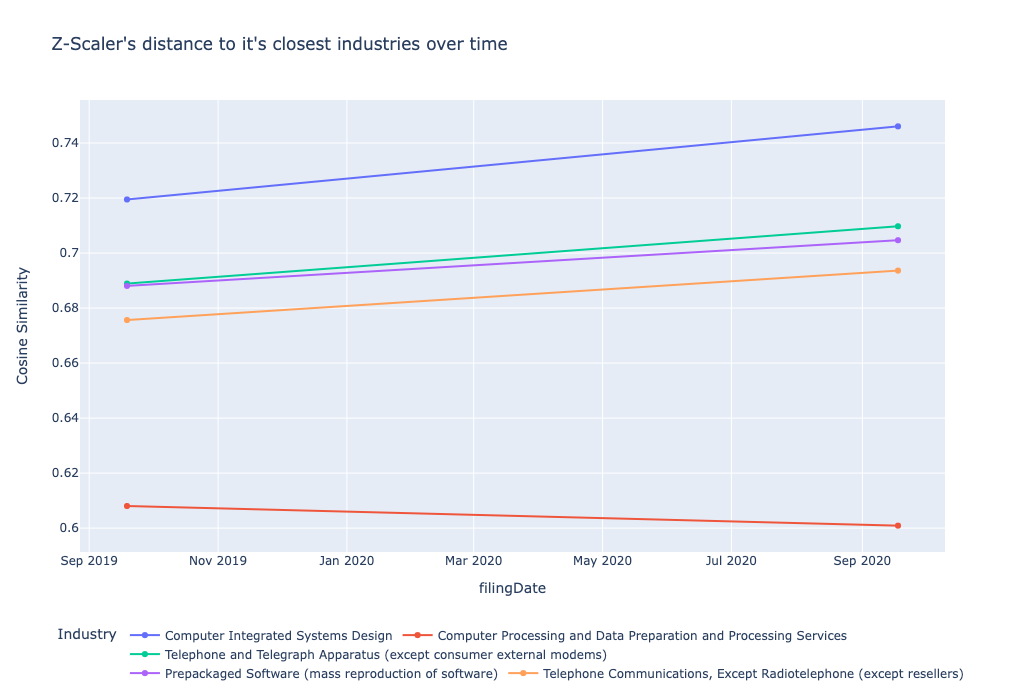

In [292]:
zs_d2v = pd.concat([data_d2v[data_d2v.loc[:,"CIK"] == 1713683].iloc[:,0].reset_index(drop=True),
           pd.DataFrame(cosine_similarity(data_d2v[data_d2v.loc[:,"CIK"] == 1713683].iloc[:,4:], industry_vectors_d2v),
                        columns = industry_vectors.index.tolist())],
          axis = 1)

# Gets the list of top industries associated with okta throughout it's history
zs_industries = set((zs_d2v.iloc[0,1:].sort_values(ascending = False).head(5).index.tolist()))
for i in np.arange(1,zs_d2v.shape[0]):
    zs_industries.update(zs_d2v.iloc[i,1:].sort_values(ascending = False).head(5).index.tolist())

std_func.dynamic_plt(zs_d2v, zs_industries, "Z-Scaler")

Across the board, it seems Z-Scaler's similarity to it's closest industries increased, in contrast to our word2vec results. This suggests that Z-Scaler is moving closer to the computer integrated systems design/modem related industries.

This interpretation should be taken with a large grain of salt as well, as we are only visualizing changes over one year and the results are not consistent with our word2vec results.

#### Netflix

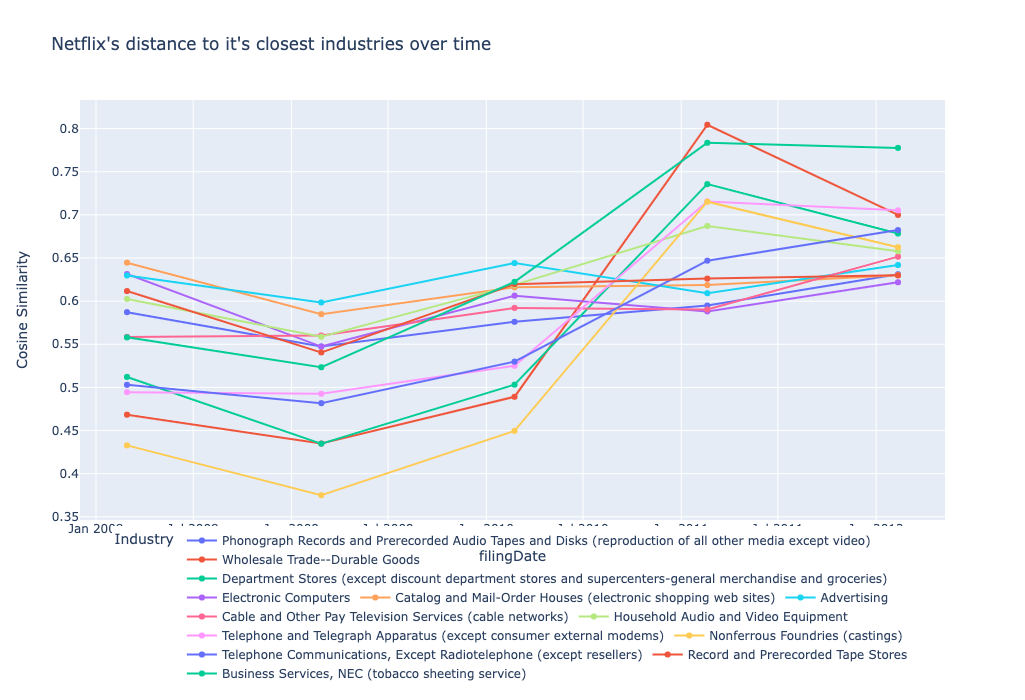

In [295]:
nlfx_d2v = pd.concat([data_d2v[data_d2v.loc[:,"CIK"] == 1065280].iloc[:,0].reset_index(drop=True),
           pd.DataFrame(cosine_similarity(data_d2v[data_d2v.loc[:,"CIK"] == 1065280].iloc[:,4:], industry_vectors_d2v),
                        columns = industry_vectors.index.tolist())],
          axis = 1)

# Gets the list of top industries associated with okta throughout it's history
nlfx_industries = set((nlfx_d2v.iloc[0,1:].sort_values(ascending = False).head(5).index.tolist()))
for i in np.arange(1,nlfx_d2v.shape[0]):
    nlfx_industries.update(nlfx_d2v.iloc[i,1:].sort_values(ascending = False).head(5).index.tolist())

std_func.dynamic_plt(nlfx_d2v, nlfx_industries, "Netflix")

A quick look at the largest increases in cosine similarity tells us that this graph is quite meaningless, although fun to look at. The largest jumps in cosine similarity occurred with the **"Wholesale Trade--Durable Goods"** industry and the **"Business Services, NEC (tobacco sheeting service)"** industry which are far crys from what Netflix's products and services are. 

As per definition,
>Industries in the Wholesale Trade, Durable Goods subsector sell or arrange the purchase or sale of capital or durable goods to other businesses. Durable goods are new or used items generally with a normal life expectancy of three years or more. Durable goods wholesale trade establishments are engaged in wholesaling products, such as motor vehicles, furniture, construction materials, machinery and equipment (including household-type appliances), metals and minerals (except petroleum), sporting goods, toys and hobby goods, recyclable materials, and parts.

This result is unfortunately not very interpretable.

#### General Electric

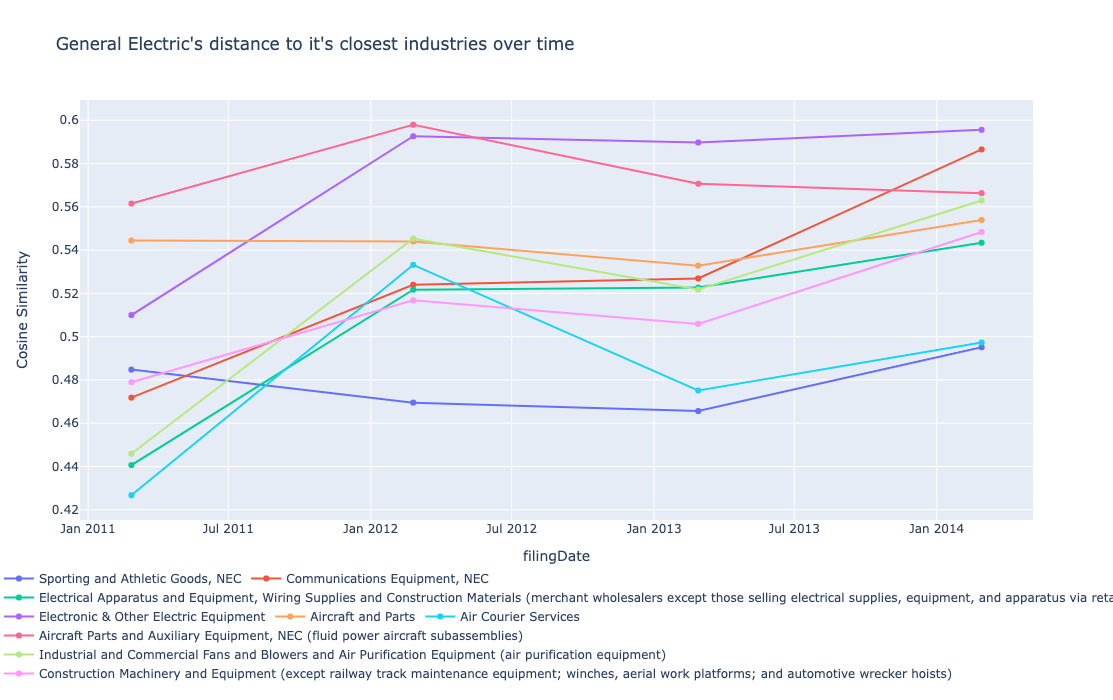

In [296]:
ge_d2v = pd.concat([data_d2v[data_d2v.loc[:,"CIK"] == 40545].iloc[:,0].reset_index(drop=True),
           pd.DataFrame(cosine_similarity(data_d2v[data_d2v.loc[:,"CIK"] == 40545].iloc[:,4:], industry_vectors_d2v),
                        columns = industry_vectors.index.tolist())],
          axis = 1)

# Gets the list of top industries associated with okta throughout it's history
ge_industries = set((ge_d2v.iloc[0,1:].sort_values(ascending = False).head(5).index.tolist()))
for i in np.arange(1,ge_d2v.shape[0]):
    ge_industries.update(ge_d2v.iloc[i,1:].sort_values(ascending = False).head(5).index.tolist())

std_func.dynamic_plt(ge_d2v, ge_industries, "General Electric")

Finally, we have General Electric. This graph is quite interesting, as GE is a multinational conglomerate which has it's hands in many industries. This graph illustrates this aspect of GE quite well, as its most similar industries are quite unrelated to eachother. Due to the scale of this company, it is also quite difficult to interpret why certain industries increased in similarity, and as we've seen above it may be best to take dynamic analysis results using doc2vec with a grain of salt.

## Conclusion

On this page, you've learned about our methodology of measuring and analyzing the changes in business descriptions. These changes helped us identify what the largest changes in each of these companies were, whether it was a increase or decrease of importance of certain terms, or a shift closer toward or further from its closest industries.

As this work is unsupervised and exploratory, its quite hard to extract any concrete results that could lead to actionable insight. This is more a look into the techniques available to perform NLP analysis. We hope this was informative to how time series data and text embeddings have mayn novel applications waiting to be explored.